# Isolation
This model will test the effectiveness of reducing mean contacts during periods of isolation. Isolation will begin when someone becomes symptomatic or if they are randomly tested.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import time

## Setup

In [2]:
size_of_model = 1000

In [3]:
df = pd.DataFrame()
ID = list(range(0,size_of_model))

In [4]:
daily_contacts_mean = 15
daily_contacts = []
for i in range (size_of_model):
    daily_contacts.append(np.random.poisson(daily_contacts_mean))

In [5]:
friend_group_mean = 5
friend_group = []
for i in range (size_of_model):
    friend_group.append(np.random.poisson(friend_group_mean))

In [6]:
status = []
for i in range(size_of_model):
    status.append('S')
r = random.sample(range(size_of_model),10)
for i in r:
    status[i] = "C"

In [7]:
friends_list = []
for i in range(size_of_model):
    friends_list.append([])

In [8]:
days_to_next_stage = []
for i in range(size_of_model):
    days_to_next_stage.append(-1)
for i in r:
    days_to_next_stage[i] = np.random.poisson(5)

In [9]:
awareness = []
for i in range(size_of_model):
    awareness.append("No")

In [10]:
def reset_df(df):
    df["ID"] = ID
    df["Friend_Group_Size"] = friend_group
    df["Friends_List"] = friends_list
    df["Daily_Contacts_Size"] = daily_contacts
    df["Status"] = status
    df["Days_To_Next_Stage"] = days_to_next_stage
    df["Aware_Of_Infection"] = awareness
    
    return df
df = reset_df(df)

## Graphing

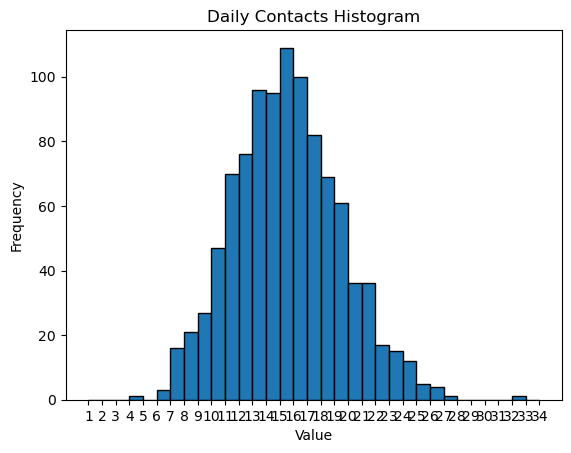

In [11]:
plt.hist(daily_contacts, bins=range(1,35), edgecolor='black')
plt.xticks(range(1,35))
plt.title('Daily Contacts Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

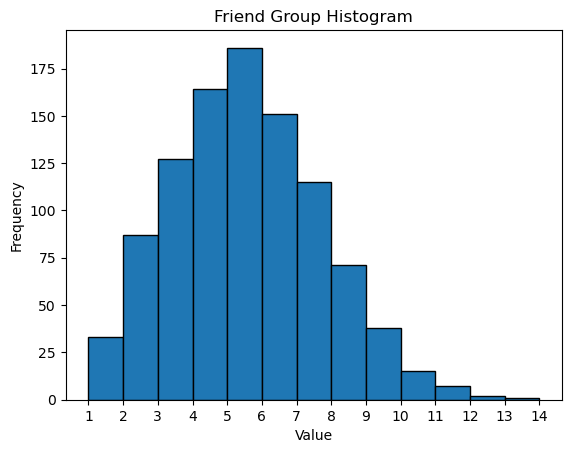

In [12]:
plt.hist(friend_group, bins=range(1,15), edgecolor='black')
plt.xticks(range(1,15))
plt.title('Friend Group Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

## Modeling

### Parameters

In [13]:
meets_friend_chance = 0.15 #Chance of meeting a friend instead of a random contact
gains_friendship_chance = 0.4 #Chance a random contact becomes a friend if there is room in both friend groups
infection_chance = 0.035 #Chance of infection from contact with someone infectious
latent_infectious_chance = 0.4 #Chance of becoming latent-infectious if latent
carrier_chance = 0.2 #Chance of becoming a carrier if latent-infectious
mean_length_of_status = {"L": 3, "LI": 2, "C": 5, "I": 5, "IS": 7, "R": 60}
isolation_reduction = 3 #Number a person will divide their mean daily contacts by if they become aware
                        #that they are infected
daily_random_tests = 50
#weekly_random_tests = 100

Stages of Infection:
Susceptible (S)
Latent (L): No symptoms showing, noncontagious. May develop symptoms and become infectious or may be latent infectious
Latent-infections (LI): No symptoms showing, contagious. May develop symptoms and become infectious or may become a carrier
Infectious (I): symptomatic and contagious. Next stage is Recovered
Carrier (C): Asymptomatic and contagious. Next stage is Recovered
Recovered (R): recovered and has immunity. 

Things to check
-Masks
-Isolation (random testing)
-Social Distancing

In [14]:
next_stage_baseline = {"L": "IS", "LI": "I", "I": "R", "IS": "R", "C": "R", "R": "S"}
next_stage_other = {"L": "LI", "LI": "C"}
infectious = ["I", "C", "LI", "IS"]
infection_rate = {"I": 0.04, "C": 0.025, "LI": 0.025, "IS": 0.04}
symptomatic = ["IS", "I"]
safe = ["S", "R"]

In [15]:
def remaining_friends(f_list, remaining_contacts):
    r_f = []
    for i in range (len(f_list)):
        if has_contacts_remaining(remaining_contacts, f_list[i]):
            r_f.append(i)
    return r_f

def has_contacts_remaining(remaining_contacts, index):
    if (remaining_contacts[index] > 0):
        return True
    return False

def infected(inf_type):
    if (random.random() < infection_rate.get(inf_type)):
            return True
    return False

def latent_infectious():
    if (random.random() < latent_infectious_chance):
            return True
    return False

def carrier():
    if (random.random() < carrier_chance):
            return True
    return False

def infect(interactor):
    global df
    df.loc[interactor, "Status"] = 'L'
    df.loc[interactor, "Days_To_Next_Stage"] = np.random.poisson(mean_length_of_status.get("L"))

def random_testing(number_of_random_tests):
    global df
    indices = df.index[df["Aware_Of_Infection"] == 'No'].tolist()
    if number_of_random_tests > len(indices):
        number_of_random_tests = len(indices)
    tests = random.sample(indices, number_of_random_tests)
    for test in tests:
        if df.loc[test, "Status"] not in safe:
            df.loc[test, "Aware_Of_Infection"] = "Yes"
            
            x = df.loc[test, "Status"]
            print(f"Number {test} found out they were {x}")

def social_interaction(interactor_1, interactor_2): 
    #has a social interaction. Removes one remaining interaction from the interactors
    #Random chance to infect the other if one of them has the virus
    #Chance to add the other as a friend if both of their friend groups are open
    global df
    global remaining_contacts
    global counter
    
    #Friendship
    if (df["Friend_Group_Size"][interactor_1] > len(df["Friends_List"][interactor_1]) 
    and df["Friend_Group_Size"][interactor_2] > len(df["Friends_List"][interactor_2])
    and interactor_1 not in df["Friends_List"][interactor_2]):
        if random.random() < gains_friendship_chance:
            df["Friends_List"][interactor_1].append(interactor_2)
            df["Friends_List"][interactor_2].append(interactor_1)
    
    #Infection
    if (df["Status"][interactor_1] in infectious and df["Status"][interactor_2] 
        not in infectious and df["Status"][interactor_2] != 'R'):
        if infected(df["Status"][interactor_1]):
            infect(interactor_2)
            #print(f"{interactor_1} infected {interactor_2}")
            
    elif (df["Status"][interactor_1] not in infectious and df["Status"][interactor_2] in infectious
          and df["Status"][interactor_1] != 'R'):
        if infected(df["Status"][interactor_2]):
            infect(interactor_1)
            #print(f"{interactor_2} infected {interactor_1}")

    #Remaining contacts for the day for the interactors are decreased
    remaining_contacts[interactor_1] -= 1
    remaining_contacts[interactor_2] -= 1
    
    if has_contacts_remaining(remaining_contacts, interactor_1) == False:
            has_no_more_contacts.add(interactor_1)
    if has_contacts_remaining(remaining_contacts, interactor_2) == False:
            has_no_more_contacts.add(interactor_2)
    counter += 2
            


def random_social_interaction(next_person): #has a social interaction with a random non friend who has contacts remaining
    possible_choices = []
    for choice in df["ID"]:
        if remaining_contacts[choice] and choice != next_person and choice not in f_list:
            possible_choices.append(choice)
    social_interaction(next_person, random.choice(possible_choices))

def advance_stages():
    global df
    for i in range(size_of_model):
        if df.loc[i, "Days_To_Next_Stage"] > 0:
            df.loc[i, "Days_To_Next_Stage"] -= 1
            
        if df.loc[i, "Days_To_Next_Stage"] == 0:
            if df.loc[i, "Status"] == "L" and latent_infectious():
                df.loc[i, "Status"] = next_stage_other.get(df.loc[i, "Status"])
                
            elif df.loc[i, "Status"] == "LI" and carrier():
                df.loc[i, "Status"] = next_stage_other.get(df.loc[i, "Status"])
                
            else:
                df.loc[i, "Status"] = next_stage_baseline.get(df.loc[i, "Status"])
                
                
            if df.loc[i, "Status"] != "S":
                df.loc[i, "Days_To_Next_Stage"] = np.random.poisson(mean_length_of_status.get(df.loc[i, "Status"]))
                
            else:
                df.loc[i, "Days_To_Next_Stage"] = -1
        if df.loc[i, "Status"] in symptomatic:
            df.loc[i, "Aware_Of_Infection"] = "Yes"

        elif df.loc[i, "Status"] == 'R' or df.loc[i, "Status"] == 'S':
            df.loc[i, "Aware_Of_Infection"] = "No"
            
                
                       
def day_model():
    global has_no_more_contacts
    global f_list
    global remaining_contacts
    global df
    global counter
    
    #remaining_contacts = list(df["Daily_Contacts_Size"])
    remaining_contacts = []
    for index, value in enumerate(df["Daily_Contacts_Size"]):
        if df.loc[index, "Aware_Of_Infection"] == "Yes":
            remaining_contacts.append(np.random.poisson(value / isolation_reduction))
        else:
            remaining_contacts.append(np.random.poisson(value))
    
    ev = sum(remaining_contacts) % 2
    has_no_more_contacts = set()
            
    current_index = 0
    counter = 0
    numbers = list(range(1000))
    random.shuffle(numbers)
    while sum(remaining_contacts) > ev: #if the sum of the number of contacts is odd, someone won't be able to interact with everyone
        next_person = numbers[current_index]
        f_list = df["Friends_List"][next_person]
        if not has_contacts_remaining(remaining_contacts, next_person):
            has_no_more_contacts.add(next_person)
            current_index += 1
        else:
            friends_with_contacts_remaining = remaining_friends(f_list, remaining_contacts)
            
            if friends_with_contacts_remaining and random.random() < meets_friend_chance:
                social_interaction(next_person, random.choice(friends_with_contacts_remaining))
                
            else:
                random_social_interaction(next_person)
    random_testing(daily_random_tests)
    advance_stages()
    

In [16]:
def week_model():
    for i in range(7):
        day_model()
    random_testing(weekly_random_tests)

In [17]:
df = reset_df(df)

In [18]:
df["Status"].value_counts()

S    990
C     10
Name: Status, dtype: int64

In [19]:
infection_counts_df = pd.DataFrame(index=range(1000), columns=range(500))
infection_counts_df[0] = df["Status"]
avg_time = 0
for i in range(1,60):
    print(f"Starting Day {i}")
    start = time.time()
    day_model()
    end = time.time()
    avg_time += end - start
    infection_counts_df[i] = df["Status"]
    print(df["Status"].value_counts())
    counter = i
avg_time /= i
print(f"The average time per day was {round(avg_time,1)} seconds")

Starting Day 1
S    989
C      9
L      1
R      1
Name: Status, dtype: int64
Starting Day 2
S     984
C       9
L       5
IS      1
R       1
Name: Status, dtype: int64
Starting Day 3
Number 528 found out they were L
S     983
C       8
L       4
IS      3
R       2
Name: Status, dtype: int64
Starting Day 4
S     980
L       6
C       6
R       4
IS      3
LI      1
Name: Status, dtype: int64
Starting Day 5
S     978
R       7
L       6
C       3
IS      3
LI      2
I       1
Name: Status, dtype: int64
Starting Day 6
S     976
R       7
IS      6
L       4
C       3
LI      2
I       2
Name: Status, dtype: int64
Starting Day 7
S     969
R      10
L       8
IS      6
LI      3
I       3
C       1
Name: Status, dtype: int64
Starting Day 8
Number 517 found out they were L
Number 943 found out they were L
S     956
L      15
R      12
IS     11
I       4
LI      2
Name: Status, dtype: int64
Starting Day 9
Number 393 found out they were L
S     941
L      24
R      15
IS     14
LI      3
I

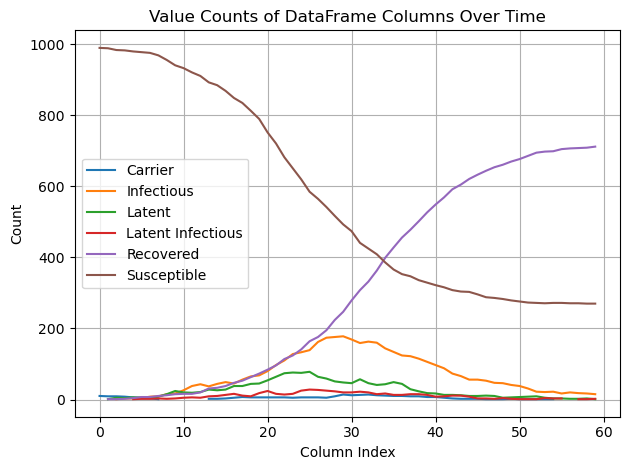

In [20]:
d = {"LI": "Latent Infectious", "L": "Latent", "R": "Recovered", "I": "Infectious", "IS" : "Infectious", "C": "Carrier", "S": "Susceptible"}
infection_counts_df = infection_counts_df.replace(d)
infection_counts_df.head()

value_counts = infection_counts_df.apply(pd.value_counts)

# Plot each row as a separate line
for index, row in value_counts.iterrows():
    plt.plot(row.index, row, label=f"{index}")

# Add labels and title
plt.xlabel('Column Index')
plt.ylabel('Count')
plt.title('Value Counts of DataFrame Columns Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
#df.to_excel("MathModeling.xlsx", index=False)

    df["ID"] = ID
    df["Friend_Group_Size"] = friend_group
    df["Friends_List"] = friends_list
    df["Daily_Contacts_Size"] = daily_contacts
    df["Status"] = status
    df["Days_To_Next_Stage"] = days_to_next_stage
    df["Aware_Of_Infection"] = awareness